## Imports

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import random
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
# from matplotlib import animation
# from JSAnimation.IPython_display import display_animation
# import gym
import scipy.stats as stats
from scipy.stats import norm
from collections import namedtuple
import statistics
import time
import os
from collections import deque
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

import yfinance as yf
import datetime as dt

import pickle

import import_ipynb
import Generate_Data
import Environment

/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'LogReturn',
       'RSI2', 'MA10', 'MA30', 'MA200', 'EMA10', 'EMA30', 'EMA200', 'ROC10',
       'ROC30', 'MOM10', 'MOM30', '%K10', '%D10', '%K30', '%D30', 'VIX',
       'RiskFreeRate', 'Volume', 'delta', 'gamma', 'theta', 'vega', 'rho'],
      dtype='object')
(3242, 30)
(434, 30)
(3242, 8)
(434, 8)
(3242, 10)
(434, 10)


<string>:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
<string>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


## Defining Model Classes
- Actor: A neural network model that represents the policy in the DDPG algorithm, mapping states to continuous actions.

- Critic: A neural network model that estimates the Q-values, evaluating the quality of state-action pairs in the DDPG framework.

- ReplayBuffer: A data structure that stores past experiences (state, action, reward, next_state, done) to facilitate experience replay during training.

- OUNoise: Implements the Ornstein-Uhlenbeck process to generate temporally correlated noise, promoting exploration in continuous action spaces.

- DDPGAgent: Encapsulates the entire DDPG agent, integrating the Actor and Critic networks, Replay Buffer, and OUNoise, and providing methods for action selection, experience memorization, and network updates.

In [38]:
# Constants
CAPACITY = 1000000  # Replay memory capacity
BATCH_SIZE = 64     # Batch size for training
GAMMA = 0.99        # Discount factor

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Ornstein-Uhlenbeck Process for exploration noise
class OrnsteinUhlenbeckProcess:
    def __init__(self, size, mu=0, theta=0.15, sigma=0.2):
        self.size = size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.size) * self.mu

    def reset_states(self):
        self.state = np.ones(self.size) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + \
             self.sigma * np.random.randn(self.size)
        self.state += dx
        return self.state

In [57]:
# AgentDDPG Class
class DDPGAgent:
    def __init__(self, env_dim, act_dim, act_range, random_process=None,
                 actor_lr=1e-3, critic_lr=1e-3, tau=1e-3):
        self.env_dim = env_dim
        self.act_dim = act_dim
        self.act_range = act_range
        self.tau = tau
        self.gamma = GAMMA

        self.random_process = random_process
        if self.random_process is not None:
            self.random_process.reset_states()

        # Actor and Critic networks
        self.actor = Actor(env_dim, act_dim, act_range).to(device)
        self.actor_target = Actor(env_dim, act_dim, act_range).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        self.critic = Critic(env_dim, act_dim).to(device)
        self.critic_target = Critic(env_dim, act_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.memory = ReplayMemory(CAPACITY)

    def get_action(self, state, step=None, episode=None):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().numpy()[0]
        self.actor.train()

        if self.random_process is not None:
            noise = self.random_process.sample()
            action += noise

        action = np.clip(action, self.act_range[0], self.act_range[1])
        return action.item()

    def memorize(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)

    def update_agent(self):
        if len(self.memory) < BATCH_SIZE:
            return

        # Sample a batch from memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch = list(zip(*transitions))
        states = torch.FloatTensor(batch[0]).to(device)
        actions = torch.FloatTensor(batch[1]).to(device)

        next_states = torch.FloatTensor([
            np.zeros(self.env_dim) if s is None else s for s in batch[2]
        ]).to(device)
        rewards = torch.FloatTensor(batch[3]).to(device)

        # Ensure actions have shape [batch_size, act_dim]
        if actions.dim() == 1:
            actions = actions.unsqueeze(1)  # Adds an extra dimension

        # Now actions should have shape [64, 1]

        # Verify shapes
        # print("States shape:", states.shape)          # Should be [batch_size, env_dim] => [64, 34]
        # print("Actions shape:", actions.shape)        # Should be [batch_size, act_dim] => [64, 1]
        # print("Next States shape:", next_states.shape)  # Should be [batch_size, env_dim] => [64, 34]
        # print("Rewards shape:", rewards.shape)        # Should be [batch_size,] => [64]

        # Compute target Q-values
        with torch.no_grad():
            next_actions = self.actor_target(next_states)
            next_Q = self.critic_target(next_states, next_actions)
            target_Q = rewards.unsqueeze(1)
            for i, s in enumerate(batch[2]):
                if s is not None:
                    target_Q[i] += self.gamma * next_Q[i]

        # Update Critic
        current_Q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update Actor
        actor_actions = self.actor(states)
        actor_loss = -self.critic(states, actor_actions).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft update of target networks
        self._soft_update(self.critic_target, self.critic)
        self._soft_update(self.actor_target, self.actor)

    def _soft_update(self, target_net, source_net):
        for target_param, param in zip(target_net.parameters(), source_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) + param.data * self.tau
            )

    # def save(self, path):
    #     torch.save(self.actor.state_dict(), path + '_actor.pth')
    #     torch.save(self.critic.state_dict(), path + '_critic.pth')

    # def load(self, path):
    #     self.actor.load_state_dict(torch.load(path + '_actor.pth'))
    #     self.critic.load_state_dict(torch.load(path + '_critic.pth'))

In [58]:
# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, act_dim, act_range):
        super(Actor, self).__init__()
        self.state_dim = state_dim
        self.act_dim = act_dim
        self.act_range = act_range

        self.fc1 = nn.Linear(state_dim, 12)
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, 12)
        self.out = nn.Linear(12, act_dim)

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.trunc_normal_(self.out.weight, std=0.01)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        action = self.out(x)
        return action

In [59]:
# Critic Network
class Critic(nn.Module):
    def __init__(self, env_dim, act_dim):
        super(Critic, self).__init__()
        self.env_dim = env_dim
        self.act_dim = act_dim

        self.fc1 = nn.Linear(env_dim + act_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, 24)
        self.out = nn.Linear(24, 1)

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.trunc_normal_(self.out.weight, std=0.01)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        Q_value = self.out(x)
        return Q_value

## Model Training

In [60]:
def train_agent(env, agent, num_episodes=1000, num_steps=30, gamma=0.99):
    """
    Trains the agent in the given environment.

    Parameters:
    - env: The trading environment (Environment).
    - agent: The DDPG agent.
    - num_episodes: The number of training episodes.
    - num_steps: The number of steps per episode.
    - gamma: Discount factor for future rewards.

    Returns:
    - pl_history: A list containing the P&L history for each episode.
    - reward_history: A list containing the cumulative reward history for each episode.
    """
    
    pl_history = []  # Profit and loss history for each episode
    reward_history = []  # Total reward history for each episode
    std_pl_history = []  # Standard deviation of P&L for each episode ; added this 

    last_30_pl = []
    
    for episode in range(num_episodes):
        state = env.reset()  # Reset the environment and get the initial state
        total_reward = 0  # Track total reward for the episode
        pl_episode = []  # Track portfolio value (P&L) for the episode

        for step in range(num_steps):
            # Agent takes an action based on the current state
            action = agent.get_action(state, step=step, episode=episode)
            
            # Environment returns the next state, reward, and whether the episode is done
            next_state, reward, done, pv = env.step(action)
            
            # Accumulate total reward, discounted by gamma (for future rewards)
            total_reward += reward * np.power(gamma, episode)
            
            # Store the portfolio value (P&L) for the step
            pl_episode.append(pv)
            
            # Memorize the experience with the done flag
            agent.memorize(state, action, next_state, reward)
            
            # Update the agent with experiences from the replay buffer
            agent.update_agent()

            # Move to the next state
            state = next_state
            
            # If the episode is done, break out of the loop
            if done:
                break
        
        # At the end of the episode, calculate the total P&L and reward
        pl_total = sum(pl_episode)
        pl_history.append(pl_total)
        reward_history.append(total_reward)

        last_30_pl.append(pl_total)
        if len(last_30_pl) > 30:
            last_30_pl.pop(0)

        if episode >= 30:
            std = np.std(last_30_pl)
            std_pl_history.append(std)
        else:
            std_pl_history.append(np.nan)

        # if episode % 30 == 0 and episode != 0:
        #     std_pl_history.append(np.std(pl_episode[-30:]))  # Compute std dev of P&L for the episode # added this
        
        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}, P&L: {pl_total}, Std Dev P&L: {std_pl_history[-1]}") # added std dev part
    
    return pl_history, reward_history, std_pl_history


Episode 0/1000, Total Reward: 56.61612528699826, P&L: -5.9365346392020655, Std Dev P&L: nan
Episode 100/1000, Total Reward: -55.16365974151569, P&L: -54.131815491669244, Std Dev P&L: 169.27140380427406
Episode 200/1000, Total Reward: -38.292792494510785, P&L: -91.29467165584022, Std Dev P&L: 152.0861296977804
Episode 300/1000, Total Reward: -51.48730810849867, P&L: -435.4461052721349, Std Dev P&L: 159.22424213049203
Episode 400/1000, Total Reward: -0.39147916490425483, P&L: 3.453302970954436, Std Dev P&L: 181.68712465765816
Episode 500/1000, Total Reward: -0.6089345749042462, P&L: -41.83883842832272, Std Dev P&L: 108.80473773064847
Episode 600/1000, Total Reward: -0.10268309108768296, P&L: 2.024414590271732, Std Dev P&L: 142.12407729085206
Episode 700/1000, Total Reward: 0.0177400528150034, P&L: 54.98508544981877, Std Dev P&L: 194.09048302853012
Episode 800/1000, Total Reward: -0.01800147588106444, P&L: 8.356922137476193, Std Dev P&L: 88.29268008364541
Episode 900/1000, Total Reward: -

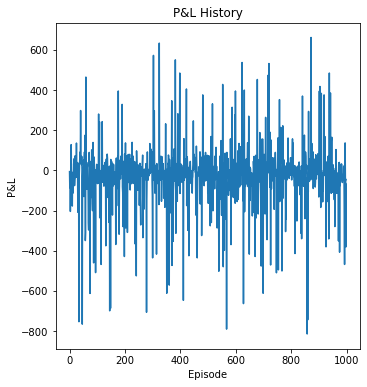

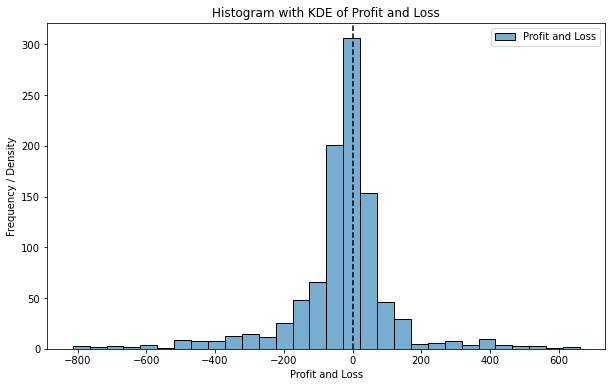

In [61]:
##Getting train datasets
features_train = Generate_Data.features_train
df_stock_train = Generate_Data.df_stock_train
call_options_train = Generate_Data.call_options_train

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up your environment with real AAPL stock and option data
env_train = Environment.Environment(
    stock_data=df_stock_train,
    option_data=call_options_train,
    features_data=features_train,
    T=30,
    n_steps=30,
    num_sold_opt=100,
    kappa=0.1,
    alpha=0.001
)
num_states = env_train.num_states
num_actions = env_train.num_actions
max_action = 10

ddpg_agent = DDPGAgent(num_states, num_actions, act_range=[-max_action, max_action])

# Train the agen
pl_history, reward_history, std_pl = train_agent(env_train, ddpg_agent, num_episodes=1000, num_steps=30)


plt.figure(figsize=(12, 6))

# Plot P&L history
plt.subplot(1, 2, 1)
plt.plot(pl_history)
plt.title("P&L History")
plt.xlabel("Episode")
plt.ylabel("P&L")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(pl_history, kde=False, bins=30, label="Profit and Loss", alpha=0.6)

plt.axvline(0, color='k', linestyle='--')  # Mark zero for reference
plt.xlabel("Profit and Loss")
plt.ylabel("Frequency / Density")
plt.title("Histogram with KDE of Profit and Loss")
plt.legend()
plt.show()

plt.show()

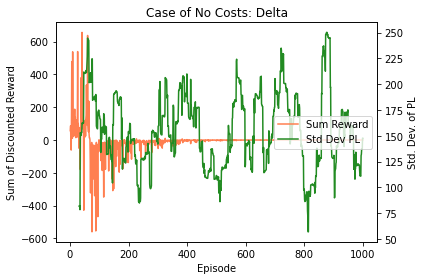

In [62]:

episodes = np.array(list(range(1, len(reward_history) + 1)))

# Create a figure for dual-axis plotting
fig = plt.figure(figsize=[6, 4])
ax1 = fig.add_subplot(111)

# Plot Sum of Discounted Reward
ax1.plot(episodes, reward_history, color='coral', label='Sum Reward')
ax1.set_xlabel('Episode')
ax1.set_ylabel("Sum of Discounted Reward")
h1, l1 = ax1.get_legend_handles_labels()

# Create a secondary axis for Std Dev PL
ax2 = ax1.twinx()
ax2.plot(episodes, std_pl, color='forestgreen', label='Std Dev PL')
ax2.set_ylabel("Std. Dev. of PL")
h2, l2 = ax2.get_legend_handles_labels()

# Combine legends for both axes and set the title
ax2.legend(h1 + h2, l1 + l2, loc='center right')
ax1.set_title('Case of No Costs: Delta')

plt.tight_layout()
plt.show()

In [63]:
import pickle

# Saving the entire agent
with open('models/ddpg_agent_full.pkl', 'wb') as f:
    pickle.dump(ddpg_agent, f)

## Notebook Summary
Train DDPG model, save as ddpg_agent_full